In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import pickle
import pandas as pd 
import numpy as np
import torch
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from openbabel import pybel
import re

In [3]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [4]:
import sys
sys.path.append('..')
sys.path.append('../evaluation')

In [5]:
from evaluation.utils_eval import build_pdb_dict, pp_match, extract_pp, extract_all_pp, group_by
from evaluation.pp_matching_specific_site import compute_center
from data_processing.ligand import Ligand

In [6]:
ligand_name = '1oty_A_rec_3occ_dih_lig_tt_docked_18'  # No 3, 17 are alright


In [7]:
bridge_type = 'vp'
root_path = os.path.join('structure_based', bridge_type, ligand_name)
# root_path = os.path.join('ligand_based', ligand_name)
aromatic = True
gen_path = os.path.join(root_path, 'aromatic' if aromatic else 'basic')

optimization = False
gen_path += '_optimized' if optimization else ''

In [8]:
score_file = os.path.join(root_path, 'aromatic_matches.pkl' if aromatic else 'basic_matches.pkl')
with open(score_file, 'rb') as f:
    matches = pickle.load(f)
matches

{'3occ_89': array([1, 1, 1, 0]),
 '3occ_27': array([1, 1, 1, 0]),
 '3occ_42': array([1, 1, 1, 0]),
 '3occ_53': array([1, 1, 1, 0]),
 '3occ_44': array([1, 1, 1, 0]),
 '3occ_81': array([1, 1, 1, 0]),
 '3occ_18': array([1, 0, 1, 0]),
 '3occ_91': array([1, 1, 1, 0]),
 '3occ_56': array([1, 1, 1, 0]),
 '3occ_69': array([1, 1, 1, 0]),
 '3occ_52': array([1, 1, 1, 0]),
 '3occ_61': array([1, 0, 1, 1]),
 '3occ_78': array([1, 1, 1, 0]),
 '3occ_67': array([1, 1, 1, 0]),
 '3occ_79': array([1, 1, 1, 0]),
 '3occ_31': array([1, 1, 1, 0]),
 '3occ_97': array([1, 1, 1, 0]),
 '3occ_30': array([1, 1, 1, 0]),
 '3occ_51': array([1, 1, 1, 0]),
 '3occ_38': array([1, 1, 1, 0]),
 '3occ_25': array([1, 1, 1, 0]),
 '3occ_37': array([1, 1, 1, 0]),
 '3occ_29': array([1, 1, 1, 0]),
 '3occ_16': array([1, 1, 1, 0]),
 '3occ_26': array([0, 1, 1, 0]),
 '3occ_41': array([1, 1, 1, 0]),
 '3occ_71': array([1, 1, 1, 0]),
 '3occ_48': array([1, 1, 1, 0]),
 '3occ_34': array([1, 1, 1, 0]),
 '3occ_20': array([1, 1, 1, 0]),
 '3occ_23'

In [9]:
test_data = torch.load(os.path.join('structure_based', ligand_name, ligand_name + '_aromatic' + '.pt' if aromatic else ligand_name + '.pt'))
center = compute_center(test_data['target_pos'], test_data['Gt_mask'])

with open(os.path.join('structure_based', ligand_name, 'pp_info.pkl'), 'rb') as f:
    pp_info = pickle.load(f)

pp_info['pp_positions'] = pp_info['pp_positions'] - center
pp_info['pp_positions']

tensor([[-0.1036, -0.2538, -2.3965],
        [ 2.5378,  1.0981,  0.9555],
        [-2.3643,  0.4101, -4.4436],
        [-3.0479,  1.5136,  0.0271]])

In [31]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)
pdb_rev_dict[ligand_name + '.sdf']

'DEOD_ECOLI_2_238_0'

In [32]:
def test_ref_ligand(gen_lig, ori_lig, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, gen_lig+'.sdf')
    m = Chem.MolFromMolFile(gen_lig)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ori_lig+'.sdf')
    print(ref_file)
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [20]:
lig_id = ligand_name[ligand_name.rfind('rec')+4:ligand_name.rfind('rec')+8]

In [21]:
for i in range(100):
    lig_file = os.path.join(gen_path, lig_id + '_' + str(i) + '.sdf')
    pbmol = next(pybel.readfile("sdf", lig_file))
    num_ring = len(pbmol.sssr)
    if num_ring >= 1:
        rings = pbmol.OBMol.GetSSSR()
        for ring in rings:
            # print(ring.Size())
            if ring.Size() == 6:
                # print(ring.IsAromatic())
                print(i)
                # print(len(ring))

1
3
4
6
7
17
17
21
24
28
30
36
39
40
45
49
55
55
60
61
64
66
67
77
84
85
90
93
98


In [22]:
idx = '17'
lig_file = os.path.join(gen_path, lig_id + '_' + idx + '.sdf')
lig_file

'structure_based/vp/1oty_A_rec_3occ_dih_lig_tt_docked_18/aromatic/3occ_17.sdf'

../../data/cleaned_crossdocked_data/raw/DEOD_ECOLI_2_238_0/1oty_A_rec_3occ_dih_lig_tt_docked_18.sdf


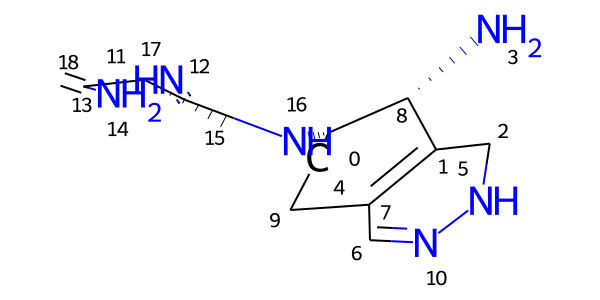

In [33]:
m, ref_m = test_ref_ligand(lig_file, ligand_name)
m

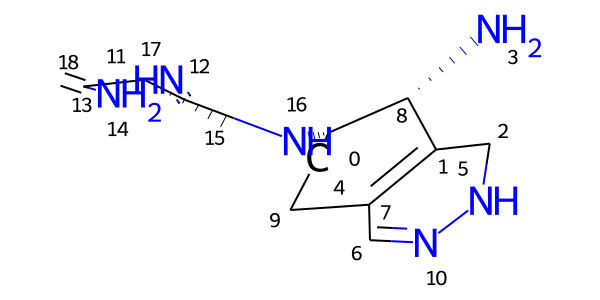

In [25]:
rdmol = Chem.MolFromMolFile(lig_file, sanitize=True)
rdmol

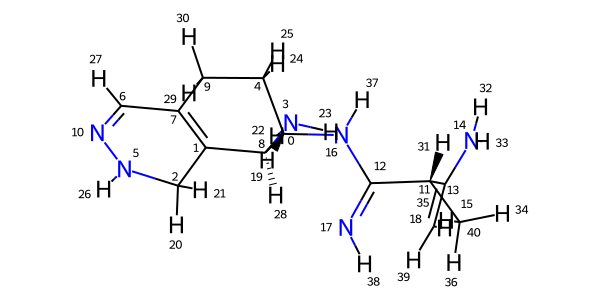

In [28]:
opt_rdmol = Chem.AddHs(rdmol, addCoords = True)
AllChem.EmbedMolecule(opt_rdmol)
UFFOptimizeMolecule(opt_rdmol)
opt_rdmol

In [34]:
with Chem.SDWriter(os.path.join('structure_based', ligand_name, lig_id + '_' + idx + '_opt.sdf')) as w:
    w.write(opt_rdmol)